In [1]:
import os
import time
from pprint import pprint

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
from catanatron_gym.envs.catanatron_env import ACTION_SPACE_SIZE
from catanatron_gym.features import get_feature_ordering

2022-01-30 10:48:18.110459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-30 10:48:18.110502: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ===== Ensure datasets exists
import pathlib
import urllib.request

# Set appropriately in cloud environments
DOWNLOAD_FROM_INTERNET = False
DATA_FOLDER = "../../../data/vf-1v1"
VALIDATION_DATA = DATA_FOLDER + '-validation'

DATASET_PATH = pathlib.Path(DATA_FOLDER, "main.csv.gzip")
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA, "main.csv.gzip")

if DOWNLOAD_FROM_INTERNET:
    DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    VALIDATION_DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    if not DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard/main.csv.gzip", DATASET_PATH)
    if not VALIDATION_DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard-validation/main.csv.gzip", VALIDATION_DATASET_PATH)

81193 samples
13 classes
Counter({0: 27816, 12: 27408, 3: 7442, 11: 5196, 1: 5064, 4: 3839, 5: 1631, 2: 1548, 6: 768, 7: 338, 8: 84, 9: 59})


<AxesSubplot:>

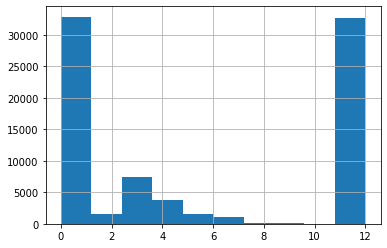

In [3]:
import pathlib
from collections import Counter

ACTIONS_DATASET_PATH = pathlib.Path(DATA_FOLDER, "actions.csv.gzip")
LABEL_COLUMN = "ACTION_TYPE"

df = pd.read_csv(ACTIONS_DATASET_PATH, compression="gzip")
NUM_SAMPLES = df.shape[0]
class_distribution = Counter(df[LABEL_COLUMN])
NUM_CLASSES = max(class_distribution.keys()) + 1
print(NUM_SAMPLES, 'samples')
print(NUM_CLASSES, 'classes')
print(class_distribution)
df[LABEL_COLUMN].hist()

In [4]:
data = pd.read_csv(DATASET_PATH, nrows=10, compression='gzip')
validation_data = pd.read_csv(VALIDATION_DATASET_PATH, nrows=10, compression='gzip')

assert (data.columns == validation_data.columns).all()
data

,F_BANK_BRICK,F_BANK_DEV_CARDS,F_BANK_ORE,F_BANK_SHEEP,F_BANK_WHEAT,F_BANK_WOOD,"F_EDGE(0, 1)_P0_ROAD","F_EDGE(0, 1)_P1_ROAD","F_EDGE(0, 20)_P0_ROAD","F_EDGE(0, 20)_P1_ROAD",...,F_TILE9_IS_WHEAT,F_TILE9_IS_WOOD,F_TILE9_PROBA,ACTION,ACTION_TYPE,RETURN,DISCOUNTED_RETURN,TOURNAMENT_RETURN,DISCOUNTED_TOURNAMENT_RETURN,VICTORY_POINTS_RETURN
0,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,106,4,1.0,0.47534,1010.0,480.093442,9.926269
1,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,45,3,1.0,0.47534,1010.0,480.093442,9.926269
2,19.0,25.0,19.0,18.0,19.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,114,4,1.0,0.47534,1010.0,480.093442,9.926269
3,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,51,3,1.0,0.47534,1010.0,480.093442,9.926269
4,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,1.0,0.47534,1010.0,480.093442,9.926269
5,17.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,289,12,1.0,0.47534,1010.0,480.093442,9.926269
6,17.0,25.0,18.0,18.0,16.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,1.0,0.47534,1010.0,480.093442,9.926269
7,17.0,25.0,18.0,18.0,16.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,289,12,1.0,0.47534,1010.0,480.093442,9.926269
8,17.0,25.0,18.0,18.0,13.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,1.0,0.47534,1010.0,480.093442,9.926269
9,17.0,25.0,17.0,18.0,12.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,243,11,1.0,0.47534,1010.0,480.093442,9.926269


In [5]:
# ===== Read Dataset
BATCH_SIZE = 128
SHUFFLE_SEED = 1
INPUT_COLUMNS = list(filter(lambda x: x.startswith("F_"), data.columns))
LABEL_COLUMN = "ACTION_TYPE"

dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,  # shuffle will shuffle at the element level. nice.
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)
validation_dataset = tf.data.experimental.make_csv_dataset(
    str(VALIDATION_DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)

def preprocess(batch, label):
    features = tf.stack(
        [tf.cast(tensor, tf.float32) 
         for feature_name, tensor in batch.items() 
         if feature_name in INPUT_COLUMNS
        ], axis=1
    )
    return features, tf.stack(label)

dataset = dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

2022-01-30 10:48:20.459699: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-30 10:48:20.519138: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-30 10:48:20.519182: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bcollazo-Erazer-X510): /proc/driver/nvidia/version does not exist
2022-01-30 10:48:20.520074: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# 100 batches take 7 secs. 1000 takes 75 secs. 10_000 takes 600 seconds
t1 = time.time()
def take_samples(x, y):
    return x

normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()
normalization_layer.adapt(dataset.map(take_samples).take(10000))
print("Normalization took:", time.time() - t1)
print(normalization_layer.mean)

2022-01-30 10:48:25.537643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-30 10:48:25.578060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3492135000 Hz


Normalization took: 59.898070335388184
<tf.Variable 'mean:0' shape=(614,) dtype=float32, numpy=
array([1.77190609e+01, 2.40749283e+01, 1.64280777e+01, 1.63756752e+01,
       1.58198261e+01, 1.73576431e+01, 8.89755562e-02, 9.07318145e-02,
       9.86035094e-02, 9.94602889e-02, 6.88307583e-02, 7.03943670e-02,
       9.44267064e-02, 9.50478613e-02, 1.07031949e-01, 1.09537974e-01,
       1.53918594e-01, 1.52376458e-01, 7.14116916e-02, 7.09619224e-02,
       1.66791573e-01, 1.65410072e-01, 5.69965914e-02, 5.59363589e-02,
       1.63053945e-01, 1.64756656e-01, 1.64596245e-01, 1.65902764e-01,
       5.67502752e-02, 5.65788969e-02, 1.61629543e-01, 1.64510414e-01,
       5.27020507e-02, 5.24022169e-02, 1.87836036e-01, 1.90331340e-01,
       1.48274675e-01, 1.48735091e-01, 1.54711083e-01, 1.53222606e-01,
       1.53950900e-01, 1.55385926e-01, 6.45254329e-02, 6.35829493e-02,
       6.98159710e-02, 6.77383840e-02, 1.69854790e-01, 1.71889260e-01,
       1.67626947e-01, 1.67102292e-01, 7.67772421e-0

In [7]:
# ===== Build Class Weights
labels_dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=[LABEL_COLUMN],
    compression_type="GZIP",
)
def count(counts, batch):
    features, labels = batch
    for i in range(NUM_CLASSES):
        class_i = labels == i
        class_i = tf.cast(class_i, tf.int32)
        counts[f"class_{i}"] += tf.reduce_sum(class_i)
    return counts

# This takes abount 3mins
start = time.time()
initial_state = {f"class_{i}": 0 for i in range(NUM_CLASSES)}
counts = labels_dataset.reduce(initial_state=initial_state, reduce_func=count)  # { "class_0": tf.Tensor, ... }
print("Computing class counts took:", time.time() - start, "seconds")

Computing class counts took: 2.6964950561523438 seconds


In [8]:
counts_array = np.array([counts[f"class_{i}"].numpy() for i in range(NUM_CLASSES)]).astype(np.float32)

fractions = counts_array/counts_array.sum()
weights = (1 / counts_array) * (counts_array.sum() / NUM_CLASSES)
weights[weights == np.inf] = -np.inf  # Drop inf to min value (to sort of "clip" importance)
weights[weights == -np.inf] = np.max(weights)  # Drop inf to min value (to sort of "clip" importance)
class_weight = {i: weights[i] for i in range(NUM_CLASSES)}
pprint(class_weight)

# {0: 0.010215329, then many in 0.5-2 range, 289: 0.010377976}

# === Rejection Resampling
# def class_func(features, label):
#     return label
# n = NUM_CLASSES
# target_dist = [1.0 / n for i in range(n)]
# resampler = tf.data.experimental.rejection_resample(
#     class_func, target_dist=target_dist)

# dataset = dataset.unbatch().apply(resampler).batch(BATCH_SIZE)\
#     .map(lambda extra_label, features_and_label: features_and_label)
# dataset

{0: 0.2243975,
 1: 1.229255,
 2: 3.9845984,
 3: 0.84183615,
 4: 1.6307969,
 5: 3.8086224,
 6: 8.121077,
 7: 18.622108,
 8: 76.25263,
 9: 104.98551,
 10: 104.98551,
 11: 1.2119793,
 12: 0.22774144}


/tmp/ipykernel_646944/2893776422.py:4: RuntimeWarning: divide by zero encountered in true_divide
  weights = (1 / counts_array) * (counts_array.sum() / NUM_CLASSES)


In [9]:
# Things to try: Dropout. Less Learning Rate. Simpler Models. Validation Graph.
INPUT_SHAPE = (len(INPUT_COLUMNS),)
LAYERS = [128, 128, 128]

inputs = tf.keras.Input(shape=INPUT_SHAPE)

last_layer = inputs
last_layer = normalization_layer(last_layer)
for num_neurons in LAYERS:
    last_layer = tf.keras.layers.Dense(num_neurons, activation="tanh", dtype='float64')(last_layer)
    # last_layer = tf.keras.layers.Dropout(0.5)(last_layer)

output_dense = tf.keras.layers.Dense(NUM_CLASSES, dtype='float64')(last_layer)
model = tf.keras.Model(inputs=inputs, outputs=output_dense)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['sparse_categorical_accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 614)]             0         
_________________________________________________________________
normalization (Normalization (None, 614)               1229      
_________________________________________________________________
dense (Dense)                (None, 128)               78720     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 13)                1677      
Total params: 114,650
Trainable params: 113,421
Non-trainable params: 1,229
___________________________________________________

In [ ]:
# class_weight = {i: 1 for i in range(290)}
# class_weight[0] = 0.01
# class_weight[289] = 0.01
# class_weight[0] = 0.1
# class_weight[289] = 0.1

history = model.fit(
    dataset, 
    epochs=25,
    # steps_per_epoch=10,
    # validation_steps=10,
    validation_data=validation_dataset,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss'),
    ]
)

Epoch 1/25
   7638/Unknown - 807s 106ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.9450

In [25]:
x, y = list(dataset.take(1).as_numpy_iterator())[0]
logits = model.predict([x])
guess = tf.nn.softmax(logits)
classes = np.argmax(guess, axis=1)
print(y)
print(classes)

[ 4 12 12  0  0  4  1  3 12  1  0  6  3  0  4  0  0 12  1  0 12 12  2  0
  3 12  6  1 11  0  0  0 12  0 12  4  0  1 12  0  5  0  6  0  0  2  0  0
  1 12  5  0 12  0 12 12 12  3  6  0  0  0  1  1 12  0  2  0 12  4 12  0
 12 12  0 12  3  0  0  3 12 12 11  2 12 12 12  1  0  0  2  2  0  0 12  0
 12  3 12  2  0  0  0  0 12  0  4  3 12  0  5  0  2 12  0  0  1  0  0  4
 12  0  1 12  3 12 12  1]
[ 4  7 12  0  0  4  1  4 12  1  0  6  3  0  4  0  0 12  1  0 12 12  2  0
  3 12  6  1 11  0  0  0 12  0 12  3  0  1 12  0  5  0  6  0  0  2  0  0
  1 12  5  0 12  0 12 12 12  3  6  0  0  0  1  1 12  0  2  0 12  4 12  0
 12 12  0 12  4  0  0  3 12 12 11  2 12 12 12  1  0  0  2  2  0  0 11  0
 12  3 12  2  0  0  0  0 12  0  4  3 12  0  5  0  2 12  0  0  1  0  0  4
 12  0  1 12  3 12 12  1]


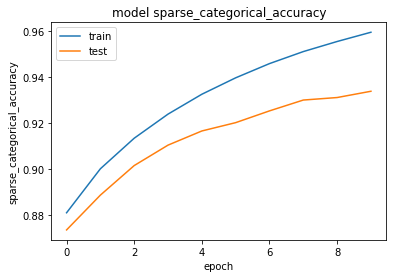

In [26]:
# summarize history for sparse_categorical_accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

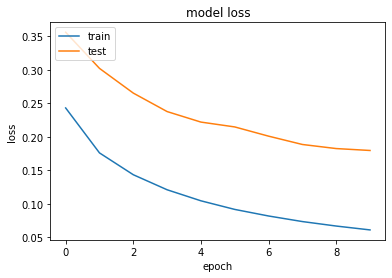

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model.save("data/models/vf-action-type-prediction-model")

INFO:tensorflow:Assets written to: data/models/vf-action-type-prediction-model/assets


In [28]:
from pprint import pprint
import random
import numpy as np
import tensorflow as tf

from catanatron.game import Game
from catanatron.models.player import Player, RandomPlayer, Color
from catanatron.models.enums import ActionType
from catanatron.players.weighted_random import WeightedRandomPlayer
from catanatron_experimental.play import play_batch
from catanatron_gym.envs.catanatron_env import to_action_space, ACTION_SPACE_SIZE, from_action_space
from catanatron_gym.features import create_sample_vector, create_sample


action_types = [i for i in ActionType]


def to_action_type_space(action):
    return action_types.index(action.action_type)


class MyPlayer(Player):
    def decide(self, game, playable_actions):
        """Should return one of the playable_actions.

        Args:
            game (Game): complete game state. read-only.
            playable_actions (Iterable[Action]): options to choose from
        Return:
            action (Action): Chosen element of playable_actions
        """
        # ===== YOUR CODE HERE =====
        action_type_ints = [to_action_type_space(a) for a in playable_actions]
        mask = np.zeros(13, dtype=np.float)
        mask[action_type_ints] = 1
        mask[mask == 0] = np.nan

        # Get action probabilities with neural network.
        vector = create_sample_vector(game, self.color)
        record = create_sample(game, self.color)
        keys = [name[2:] for name in INPUT_COLUMNS] # remove the F_ prefix
        vector = [record[x] for x in keys]
        X = [vector]
        result = model.call(tf.convert_to_tensor(X))

        # Multiply mask with output, and take max.
        clipped_probabilities = np.multiply(mask, result[0])
        clipped_probabilities[np.isnan(clipped_probabilities)] = -np.inf
        action_type_index = np.argmax(clipped_probabilities)
        predicted_action_type = action_types[action_type_index]
        # if predicted_action_type == ActionType.MARITIME_TRADE:
        #     return random.choice(playable_actions)
        
        actions_of_predicted_type = list(filter(
            lambda a: a.action_type == predicted_action_type, 
            playable_actions))
        return random.choice(actions_of_predicted_type)
        # ===== END YOUR CODE =====

# Play a simple 4v4 game. Edit MyPlayer with your logic!
players = [
    MyPlayer(Color.RED),
    RandomPlayer(Color.WHITE),
]
wins, results_by_player, games = play_batch(25, players)

pprint(wins)
pprint(results_by_player)

# Results: [64, 32, 32] with LR 1e-4 made a bot that won 60% of games against Random. Had %60 categorical accuracy.

Output()

                     Last 10 Games                     
     ╷           ╷       ╷        ╷          ╷         
   # │ SEATING   │ TURNS │ RED VP │ WHITE VP │ WINNER  
╶────┼───────────┼───────┼────────┼──────────┼────────╴
  16 │ WHITE,RED │   110 │      3 │       10 │ WHITE   
  17 │ RED,WHITE │  1000 │      5 │        9 │         
  18 │ RED,WHITE │   639 │      7 │       10 │ WHITE   
  19 │ WHITE,RED │   420 │      4 │       10 │ WHITE   
  20 │ RED,WHITE │   289 │      7 │       10 │ WHITE   
  21 │ WHITE,RED │   318 │      4 │       10 │ WHITE   
  22 │ WHITE,RED │   169 │     11 │        3 │ RED     
  23 │ RED,WHITE │   333 │      3 │       10 │ WHITE   
  24 │ RED,WHITE │   302 │     10 │        5 │ RED     
  25 │ RED,WHITE │   525 │      5 │       11 │ WHITE   
     ╵           ╵       ╵        ╵          ╵

                                       Player Summary                                        
                     ╷      ╷        ╷          ╷          ╷          ╷          ╷           
                     │      │        │      AVG │      AVG │          │          │  AVG DEV  
                     │ WINS │ AVG VP │  SETTLES │   CITIES │ AVG ROAD │ AVG ARMY │       VP  
╶────────────────────┼──────┼────────┼──────────┼──────────┼──────────┼──────────┼──────────╴
  MyPlayer:RED       │   11 │   6.96 │     2.46 │     1.29 │     0.42 │     0.17 │     0.75  
  RandomPlayer:WHITE │   13 │   8.04 │     2.00 │     0.92 │     0.50 │     0.75 │     1.71  
                     ╵      ╵        ╵          ╵          ╵          ╵          ╵

              Game Summary              
            ╷           ╷               
  AVG TICKS │ AVG TURNS │ AVG DURATION  
╶───────────┼───────────┼──────────────╴
     764.50 │    297.83 │   1.188 secs  
            ╵           ╵

{<Color.RED: 'RED'>: 11, <Color.WHITE: 'WHITE'>: 13}
{<Color.RED: 'RED'>: [10,
                      3,
                      7,
                      10,
                      10,
                      5,
                      3,
                      10,
                      3,
                      10,
                      10,
                      10,
                      10,
                      2,
                      10,
                      3,
                      7,
                      4,
                      7,
                      4,
                      11,
                      3,
                      10,
                      5],
 <Color.WHITE: 'WHITE'>: [6,
                          10,
                          10,
                          9,
                          5,
                          10,
                          11,
                          4,
                          10,
                          9,
                          5,
           